# Develop the Reduction Code for this data

In [1]:
import os
import glob

from dataclasses import dataclass
from collections.abc import MutableMapping

import numpy as np
import matplotlib.pyplot as plt

import ccdproc as ccdp

from astropy.nddata import CCDData
from astropy.visualization import hist
from astropy.stats import mad_std
from astropy import units as u

from util import *

ccdp_combine_kwargs = dict(
    method="average",
    sigma_clip=True,
    sigma_clip_low_thresh=5,
    sigma_clip_high_thresh=5,
    sigma_clip_func=np.ma.median,
    sigma_clip_dev_func=mad_std
)

In [2]:
# Organize the files into these data structures defined above
files = ReductionFiles(os.path.join(os.environ["HOME"], "instrumentation_project", "my-data"))
files.read_and_organize("AT2024wsd")

dict(files.target_files)

{'b': ['/home/noahf/instrumentation_project/my-data/AT2024wsd_b.OBJECT.0210.fits',
  '/home/noahf/instrumentation_project/my-data/AT2024wsd_b.OBJECT.0209.fits',
  '/home/noahf/instrumentation_project/my-data/AT2024wsd_b.OBJECT.0211.fits'],
 'r': ['/home/noahf/instrumentation_project/my-data/AT2024wsd_r.OBJECT.0215.fits',
  '/home/noahf/instrumentation_project/my-data/AT2024wsd_r.OBJECT.0217.fits',
  '/home/noahf/instrumentation_project/my-data/AT2024wsd_r.OBJECT.0216.fits'],
 'u': ['/home/noahf/instrumentation_project/my-data/AT2024wsd_u.OBJECT.0212.fits',
  '/home/noahf/instrumentation_project/my-data/AT2024wsd_u.OBJECT.0214.fits',
  '/home/noahf/instrumentation_project/my-data/AT2024wsd_u.OBJECT.0213.fits'],
 'v': ['/home/noahf/instrumentation_project/my-data/AT2024wsd_v.OBJECT.0219.fits',
  '/home/noahf/instrumentation_project/my-data/AT2024wsd_v.OBJECT.0218.fits',
  '/home/noahf/instrumentation_project/my-data/AT2024wsd_v.OBJECT.0220.fits']}

# Bias Reduction

We will skip overscan subtraction, for now, but will still trim the images

(<Figure size 640x480 with 2 Axes>, <Axes: >)

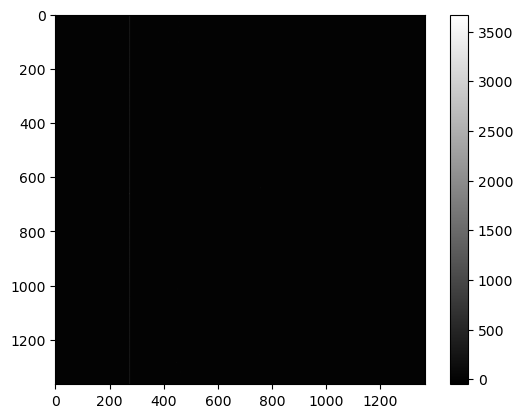

In [3]:
idx = 10
CustomCCDData.read(files.bias_files["none"][idx]).show_image()

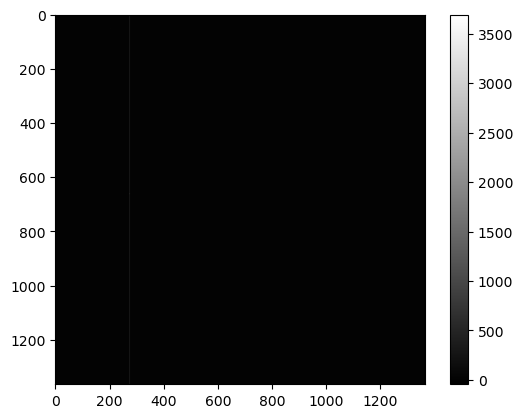

In [4]:
bias_data = [CustomCCDData.read(bias_file) for bias_file in files.bias_files["none"]]

combined_bias = ccdp.combine(
    bias_data,
    **ccdp_combine_kwargs
)

combined_bias.show_image()

combined_bias.write(os.path.join(files.datadir, "COMBINED_BIAS.fits"), overwrite=True)

# Calibrating and stacking the darks

(<Figure size 640x480 with 2 Axes>, <Axes: >)

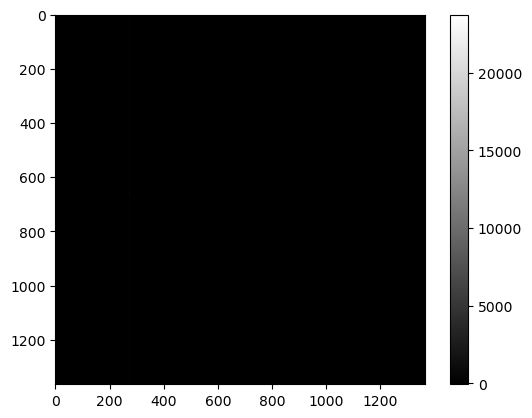

In [5]:
idx = 0
CustomCCDData.read(files.dark_files["none"][idx]).show_image()

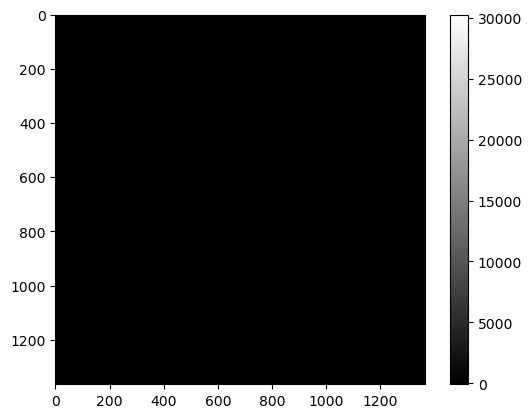

In [6]:
# subtract the bias from the dark frames
combined_dark_fifty = single_dark_calib_stack("FIFTY", files, combined_bias)
combined_dark_thirty = single_dark_calib_stack("THIRTY", files, combined_bias)
combined_dark_five = single_dark_calib_stack("FIVE", files, combined_bias)

combined_dark_fifty.show_image()
combined_dark_fifty.write(os.path.join(files.datadir, "COMBINED_DARKS_FIFTY.fits"), overwrite=True)

### Calibrating and combining Flats

(<Figure size 640x480 with 2 Axes>, <Axes: >)

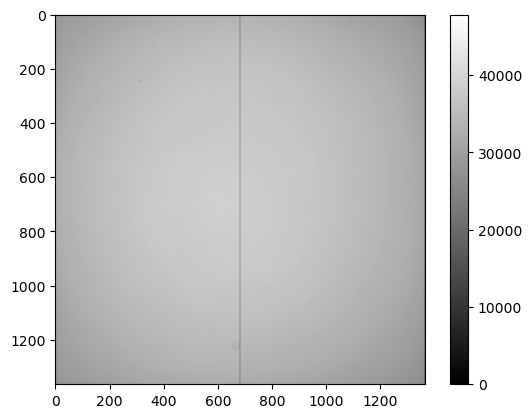

In [7]:
idx = 0
test_filt = "r"
CustomCCDData.read(files.flat_files[test_filt][idx]).show_image()

In [8]:
dict(files.flat_files)

{'b': ['/home/noahf/instrumentation_project/my-data/b.FLAT.0169.fits',
  '/home/noahf/instrumentation_project/my-data/b.FLAT.0171.fits',
  '/home/noahf/instrumentation_project/my-data/b.FLAT.0166.fits',
  '/home/noahf/instrumentation_project/my-data/b.FLAT.0160.fits',
  '/home/noahf/instrumentation_project/my-data/b.FLAT.0165.fits',
  '/home/noahf/instrumentation_project/my-data/b.FLAT.0164.fits',
  '/home/noahf/instrumentation_project/my-data/b.FLAT.0162.fits',
  '/home/noahf/instrumentation_project/my-data/b.FLAT.0161.fits',
  '/home/noahf/instrumentation_project/my-data/b.FLAT.0159.fits',
  '/home/noahf/instrumentation_project/my-data/b.FLAT.0163.fits',
  '/home/noahf/instrumentation_project/my-data/b.FLAT.0157.fits',
  '/home/noahf/instrumentation_project/my-data/b.FLAT.0158.fits',
  '/home/noahf/instrumentation_project/my-data/b.FLAT.0170.fits',
  '/home/noahf/instrumentation_project/my-data/b.FLAT.0168.fits',
  '/home/noahf/instrumentation_project/my-data/b.FLAT.0167.fits'],
 'r'

In [9]:
combined_flats = dict(
    r = single_flat_calib_and_combine(files, "r", combined_dark_five, combined_bias, 5*u.s),
    b = single_flat_calib_and_combine(files, "b", combined_dark_five, combined_bias, 5*u.s),
    v = single_flat_calib_and_combine(files, "v", combined_dark_five, combined_bias, 5*u.s),
    u = single_flat_calib_and_combine(files, "u", combined_dark_thirty, combined_bias, 30*u.s)
)

combined_flats

{'r': CustomCCDData([[30945.86625163, 10030.39907633, 10007.19829102, ...,
                  9262.70374349,  9303.15170492, 29410.60661214],
                [35446.57056071,  9808.64349365,  9829.7494751 , ...,
                  9111.18528239,  9076.96881104, 36189.21372884],
                [34970.70281982,  9794.54256185,  9849.93467204, ...,
                  9057.54283447,  8990.58640137, 38061.65989583],
                ...,
                [28804.3434611 ,  8529.24250081,  8567.90679118, ...,
                  8732.1355835 ,  8645.93325195, 37503.46135661],
                [27870.56006673,  8483.32052816,  8536.78401286, ...,
                  8720.29295247,  8716.30235596, 36568.70369975],
                [26261.65905762,  8509.09995931,  8547.57504476, ...,
                  8774.2831665 ,  8701.61390381, 33738.32974447]], unit='adu'),
 'b': CustomCCDData([[30116.84951986,  9667.74321696,  9677.13888346, ...,
                  9100.33212891,  9178.3396932 , 30195.63363037],
   

(<Figure size 640x480 with 2 Axes>, <Axes: >)

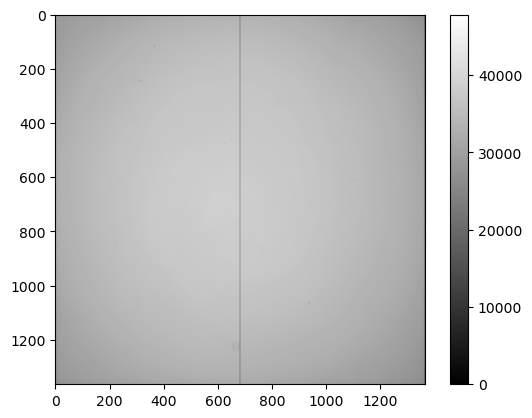

In [10]:
combined_flats['r'].show_image()

# Reduce the science images from all of these calibrations

In [12]:
exptime = 50*u.s

combined_obj_images = {}

for filt, filt_files in files.target_files.items():
    calib_data = []
    for f in filt_files:
        
        data = CustomCCDData.read(f)
        
        reduced = ccdp.subtract_bias(
            data,
            combined_bias
        )
        
        reduced = ccdp.subtract_dark(
            reduced, 
            combined_dark_fifty,
            dark_exposure=exptime,
            data_exposure=exptime
        )
        
        reduced = ccdp.flat_correct(
            reduced,
            combined_flats[filt]
        )
        
        calib_data.append(reduced)
        
    combined_obj_images[filt] = ccdp.combine(calib_data, **ccdp_combine_kwargs)
    
combined_obj_images

/home/noahf/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/noahf/anaconda3/lib/python3.11/site-packages/astropy/nddata/nduncertainty.py:881: RuntimeWarning: invalid value encountered in divide
  (left + right + correlation_sign * corr)
/home/noahf/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/noahf/anaconda3/lib/python3.11/site-packages/astropy/nddata/nduncertainty.py:881: RuntimeWarning: invalid value encountered in divide
  (left + right + correlation_sign * corr)
/home/noahf/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/noahf/anac

{'b': CustomCCDData([[ 938.37320977,  855.88418992, 1026.48907172, ...,
                  967.67736439, 1044.4129501 ,  965.30214099],
                [ 882.216756  ,  883.19228885,  852.33210281, ...,
                  841.37698939,  825.32373506,  827.92772351],
                [ 890.3996078 ,  857.30474203,  886.18158255, ...,
                  808.4438016 ,  782.58715567,  841.67392315],
                ...,
                [ 811.56625237,  796.22056025,  836.96917234, ...,
                  840.20273791,  803.2483173 ,  813.29681639],
                [ 814.8455649 ,  807.8103475 ,  832.37338303, ...,
                  800.3896542 ,  807.65430675,  814.37258352],
                [ 813.46899504,  792.79109438,  862.03582719, ...,
                  844.50828114,  795.26832987,  794.34222345]], unit='adu'),
 'r': CustomCCDData([[1617.62034722, 1513.37262736, 1750.48583837, ...,
                 1758.1380413 , 1798.99959559, 1567.91108154],
                [1560.15019299, 1591.23443837

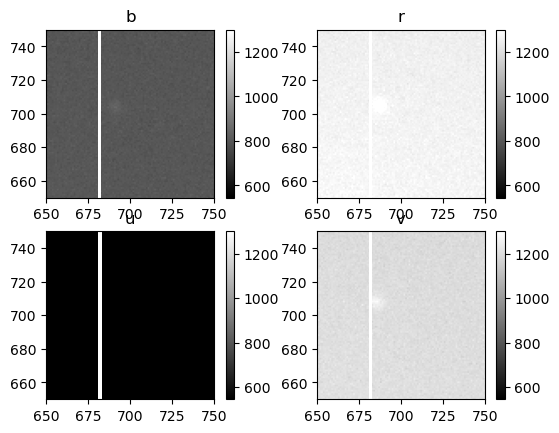

In [13]:
from matplotlib.colors import Normalize as Normalizer

fig, axs = plt.subplots(2,2)
for ax, (filt, data) in zip(axs.flatten(), combined_obj_images.items()):
    
    data.show_image(
        ax=ax, 
        fig=fig, 
        norm=Normalizer(
            vmin=545, 
            vmax=1300
        )
    )
    ax.set_title(filt)
    ax.set_xlim(650,750)
    ax.set_ylim(650,750)
    
    data.write(os.path.join(os.environ["HOME"], "instrumentation_project", "my-data", f"AT2024wsd_{filt}.REDUCED.FITS"), overwrite=True)